# KMeans

In [1]:
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [2]:
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

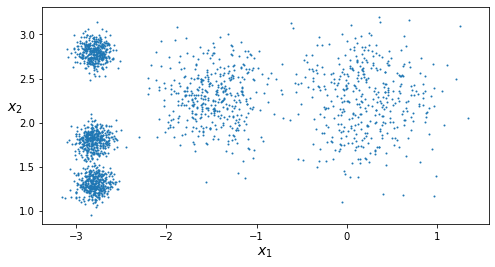

In [3]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [4]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [5]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [6]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [7]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
def plot_centroids(centroids, weights=None):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker="o", s=35, linewidth=8, color="w", zorder=11, alpha=1)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2, linewidths=12,color="k", zorder=11, alpha=1)
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

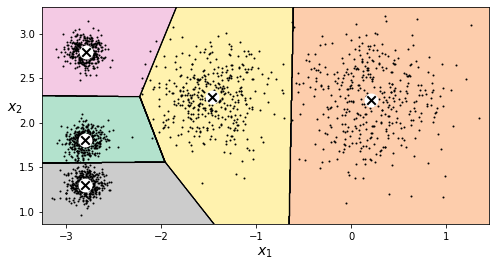

In [8]:
plt.figure(figsize=[8, 4])
plot_decision_boundaries(kmeans, X)
plt.show()

In [9]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [10]:
# example what to do if set doesnt fit memory
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], random_state=42)

In [12]:
# write to memmap
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)
X_mm[:] = X_train

In [13]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

In [14]:
# or when data is too large to memmap
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [15]:
k = 5
n_init = 10
n_iter = 100
batch_size = 100
init_size = 500
evaluate_on_last_n_iters = 100

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)

    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_interia_ = 0
    for iter in range(n_iter):
        X_batch = load_next_batch(init_size)
        minibatch_kmeans.partial_fit(X_batch)
        
        if iter >= n_iter - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_interia_ += minibatch_kmeans.inertia_

    if best_kmeans is None or minibatch_kmeans.sum_interia_ < best_kmeans.sum_interia_:
        best_kmeans = minibatch_kmeans

In [16]:
best_kmeans.score(X)

-211.63013683047336

In [17]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

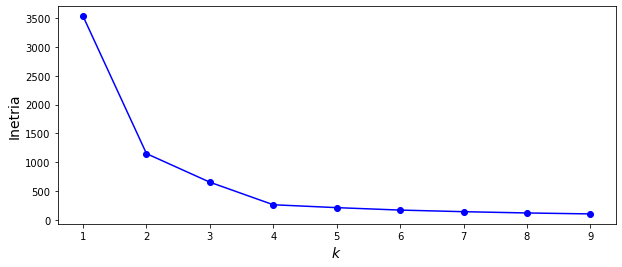

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inetria", fontsize=14)
plt.show()

# for that 4 looks the best

In [19]:
from sklearn.metrics import silhouette_score

# expensive computation, note that for n_cluster=1 doesn't exists
scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

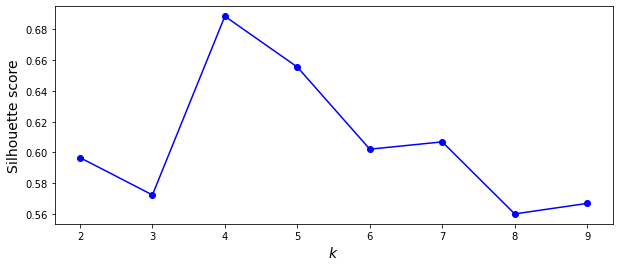

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(range(2, 10), scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

# for that 4 looks the best again, but 5 is good as well

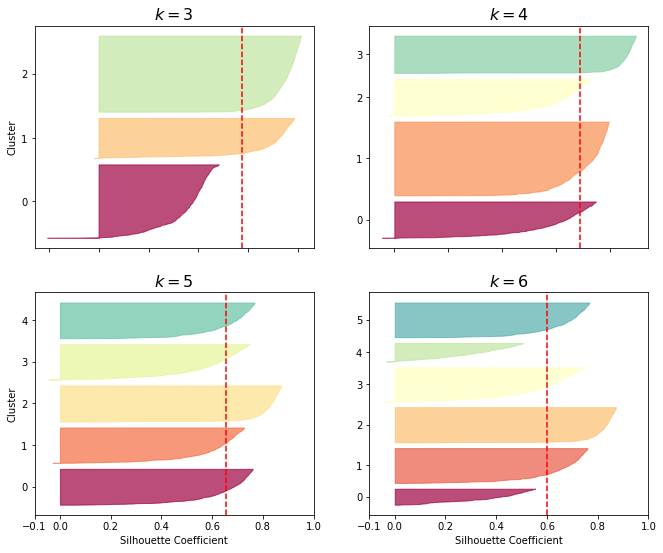

In [21]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()
# here k looks better

# Color segmentation with KMeans

In [22]:
# download the images
import os
import urllib

images_path = os.path.join("downloands", "images", "chapter9")
os.makedirs(images_path, exist_ok=True)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"

url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('downloands/images/chapter9/ladybug.png',
 <http.client.HTTPMessage at 0x143d98b50>)

In [23]:
from matplotlib.image import imread

image = imread(os.path.join(images_path, filename))
image.shape
# height, width, RGB

(533, 800, 3)

In [24]:
# list of RGB colors
X = image.reshape(-1, 3)

kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

In [25]:
# replace original color with cluster
segmented_img = kmeans.cluster_centers_[kmeans.labels_]

# reshape image back
segmented_img = segmented_img.reshape(image.shape)

In [26]:
segmented_imgs = []

n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

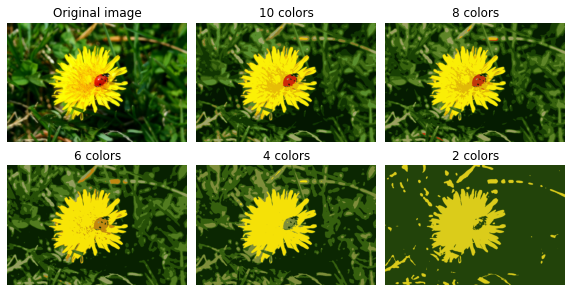

In [27]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis("off")

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title(f"{n_clusters} colors")
    plt.axis("off")

plt.show()

In [28]:
# dimentionality reduction using clustering
from sklearn.datasets import load_digits

X_dig, y_dig = load_digits(return_X_y=True)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dig, y_dig)

In [30]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [31]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9577777777777777

In [32]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [33]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.98

In [34]:
# how much did the error rate drop?

1 - (1 - pipeline_score) / (1 - log_reg_score)

0.5263157894736843

In [35]:
# lets check if some other k will get better
from sklearn.model_selection import GridSearchCV

param_grid = {
    "kmeans__n_clusters": range(2, 150)
}
grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)

In [36]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'kmeans__n_clusters': range(2, 150)})

In [37]:
grid.best_params_

{'kmeans__n_clusters': 65}

In [38]:
grid.score(X_test, y_test)
# in this case clustering didn't help

0.98

In [39]:
# Clustering for semi-supervised learning

n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42).fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8755555555555555

In [40]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train, y_train)

In [51]:
np.random.seed(42)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

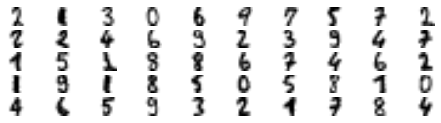

In [52]:
# let's manually label these digits

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show()

In [53]:
y_train[representative_digit_idx]

array([2, 1, 3, 0, 6, 9, 7, 5, 7, 2, 2, 2, 4, 6, 9, 2, 3, 9, 4, 7, 1, 5,
       1, 8, 8, 6, 7, 4, 6, 2, 1, 9, 1, 8, 5, 0, 5, 8, 1, 0, 4, 6, 5, 9,
       3, 2, 1, 7, 8, 4])

In [54]:
y_representative_digits = y_train[representative_digit_idx].copy()

In [55]:
# we've got data with just 50 labeled instances, but each one of them is representative for its own cluster

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

# we still learn only on 50 instances, but it already got better

0.9133333333333333

In [56]:
# label propagation

y_train_propagated = np.empty(len(X_train), dtype=np.int32)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [57]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_train, y_train_propagated)

0.9242761692650334

In [58]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [59]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [60]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [61]:
log_reg.score(X_test, y_test)

0.94

In [62]:
# boost because these instances are indeed very well labeled
np.mean(y_train_partially_propagated == y_train[partially_propagated])

# their accuracy is 96%

0.963110667996012

In [63]:
# DBSCAN clustering

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [65]:
dbscan.labels_[:10]

# -1 stands for anomaly

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [70]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")

    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.title(f"eps={dbscan.eps}, min_samples={dbscan.min_samples}")

    

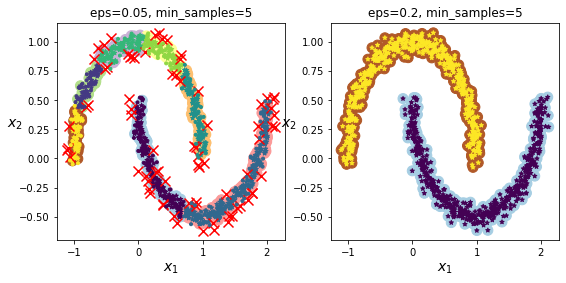

In [71]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_dbscan(dbscan, X, 100)

dbscan2 = DBSCAN(eps=0.2, min_samples=5).fit(X)
plt.subplot(122)
plot_dbscan(dbscan2, X, 100)

plt.show()

In [75]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

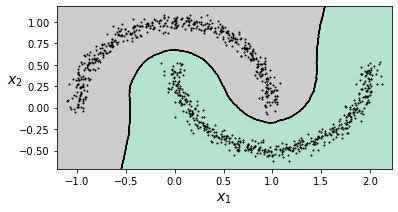

In [76]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.show()

In [80]:
# Spectral Clustering 
from sklearn.cluster import SpectralClustering

sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [81]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

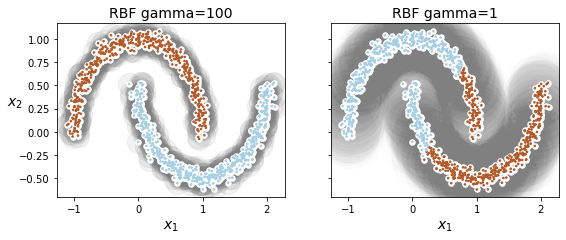

In [82]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

In [83]:
from sklearn.cluster import AgglomerativeClustering

X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)

agg = AgglomerativeClustering(linkage="complete").fit(X)

In [84]:
def learned_params(estimator):
    return [
        attrib for attrib in dir(estimator)
        if attrib.endswith("_") and not attrib.startswith("_")
    ]

In [85]:
learned_params(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [86]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

In [90]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [91]:
from sklearn.mixture import GaussianMixture

# n_init - run for 10 times, take best solution
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [92]:
gm.weights_

array([0.20954915, 0.40004337, 0.39040749])

In [93]:
gm.means_

array([[ 3.40011393,  1.05931676],
       [-1.40765148,  1.42718339],
       [ 0.0516183 ,  0.07550754]])

In [94]:
gm.converged_

True

In [95]:
gm.n_iter_

4

In [96]:
# allows for hard and soft clustering
gm.predict(X)

array([2, 2, 1, ..., 0, 0, 0])

In [97]:
gm.predict_proba(X)

array([[2.30956994e-02, 6.73632768e-07, 9.76903627e-01],
       [1.63176388e-02, 6.72738827e-04, 9.83009622e-01],
       [1.96800317e-06, 9.99922105e-01, 7.59268139e-05],
       ...,
       [9.99999561e-01, 2.09167854e-26, 4.38851876e-07],
       [1.00000000e+00, 1.41536116e-41, 5.40181989e-16],
       [1.00000000e+00, 7.72772760e-41, 2.38611270e-15]])

In [98]:
# model density at location
gm.score_samples(X)

array([-2.60806011, -3.57076496, -3.3306168 , ..., -3.51374548,
       -4.39785401, -3.80701199])

In [99]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

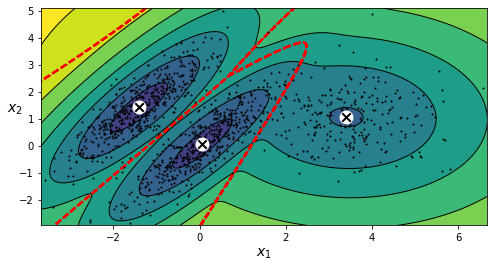

In [100]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

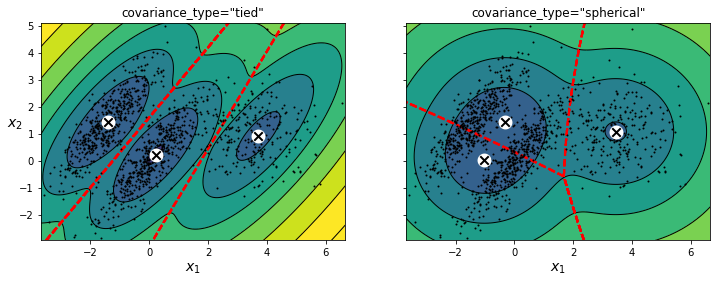

In [106]:
gm1 = GaussianMixture(n_components=3, n_init=10, covariance_type="tied")
gm2 = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical")

gm1.fit(X)
gm2.fit(X)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.title('covariance_type="tied"')
plot_gaussian_mixture(gm1, X)

plt.subplot(122)
plt.title('covariance_type="spherical"')
plot_gaussian_mixture(gm2, X, show_ylabels=False)

plt.show()


In [107]:
# anomaly detection

densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

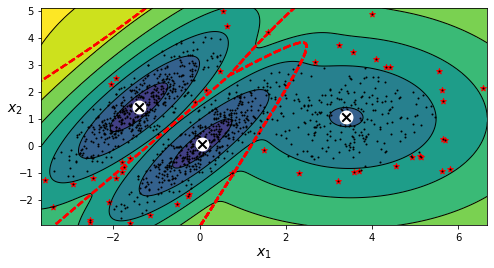

In [108]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

In [109]:
gm.bic(X)

8189.718049665739

In [110]:
gm.aic(X)

8102.492769550701

In [112]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X) for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

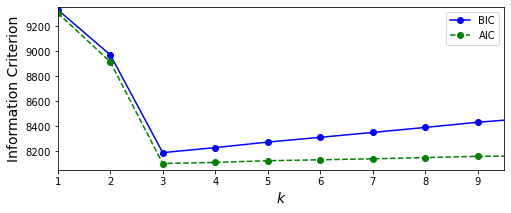

In [114]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.legend()
plt.show()

In [115]:
# searching for best gm with BIC

min_bic = float("inf")
best_model = None
for k in range(1, 11):
    for covariance_type_ in ("full", "tied", "spherical", "diag"):
        model = GaussianMixture(n_components=k, n_init=10, covariance_type=covariance_type_, random_state=42).fit(X)
    
    bic = model.bic(X)
    if bic < min_bic:
        min_bic = bic
        best_model = model

best_model

GaussianMixture(covariance_type='diag', n_components=9, n_init=10,
                random_state=42)

In [116]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10)

In [117]:
bgm.n_features_in_

2

In [121]:
np.round(bgm.weights_, 2)

# 40% of data will be assigned to class 1, 21% to class 2 and so on

array([0.4 , 0.21, 0.  , 0.  , 0.39, 0.  , 0.  , 0.  , 0.  , 0.  ])

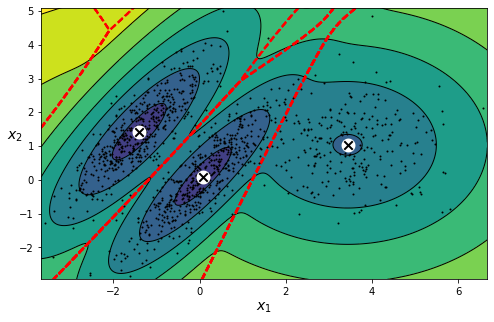

In [122]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()